In [1]:
train_dir = "/kaggle/input/compcarssv-traintest/CompcarsSV_Train/content/CompCarsSV_train_test/train"
test_dir = "/kaggle/input/compcarssv-traintest/CompcarsSV_Test/content/CompCarsSV_train_test/val"

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, InputLayer, BatchNormalization, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

2024-08-17 03:54:09.803744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 03:54:09.803870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 03:54:09.955994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
img_width, img_height = 400, 400
batch_size = 16
epochs = 100
num_classes = 281

In [5]:
train_datagen = ImageDataGenerator( rescale=1./255, rotation_range=25, width_shift_range=0.25,
                                   height_shift_range=0.25, shear_range=0.25, zoom_range=0.25,
                                   horizontal_flip=True, fill_mode='nearest' )

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory( train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size, class_mode='categorical',
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory( test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size, class_mode='categorical',
                                                  shuffle=False )

Found 31010 images belonging to 281 classes.
Found 13471 images belonging to 281 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras.layers import *

In [7]:
num_heads = 5
reduction_ratio = 8
dropout_rate = 0.02
l2_reg = 0.001
simam_lambda = 0.0001

In [8]:

class SimAM(tf.keras.layers.Layer):
    def __init__(self, eps=0.0001, activation=tf.nn.sigmoid, trainable=True, name=None, **kwargs):
        super(SimAM, self).__init__(name=name, trainable=trainable, **kwargs)
        self.activation = activation
        self.eps = eps

    def build(self, input_shape):
        self.height, self.width, self.channels = input_shape[1], input_shape[2], input_shape[3]
        self.norm = 4. / (self.height * self.width - 1)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        minus_mu_square = tf.square(inputs - tf.reduce_mean(inputs, axis=(1, 2), keepdims=True))
        out = minus_mu_square / tf.maximum(
            tf.reduce_sum(minus_mu_square, axis=(1, 2), keepdims=True) * self.norm,
            self.eps) + 0.5
        return inputs * self.activation(out)

In [9]:
class CSA(layers.Layer):
    def __init__(self, num_heads, channels, dropout_rate=0.02,l2_reg=0.001, **kwargs):
        super(CSA, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.head_channels = channels // num_heads
        self.heads = []

        for _ in range(num_heads):
            self.heads.append(self.build_SA_block(channels=self.head_channels,
                                                              dropout_rate=dropout_rate,
                                                              l2_reg=l2_reg))

        self.simam = SimAM(eps=0.0001, activation=tf.nn.sigmoid)
        self.dropout = layers.Dropout(dropout_rate)
        self.batch_norm = layers.BatchNormalization()

    def build_SA_block(self, channels, dropout_rate, l2_reg):
        input_tensor = tf.keras.Input(shape=(6, 6, channels))

        # Channel-wise attention Global features
        input_channels = channels

        conv_before_attention0 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(input_tensor)

        conv_before_attention1 = DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention0)

        conv_before_attention2 = DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention0)

        conv_before_attention3 = Multiply()([conv_before_attention1, conv_before_attention2])

        conv_before_attention4 = DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention3)

        conv_before_attention5 = DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention3)

        conv_before_attention6 = Multiply()([conv_before_attention4, conv_before_attention5])

        conv_before_attention7 = DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention6)

        conv_before_attention8 = DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention6)

        conv_before_attention9 = Multiply()([conv_before_attention7, conv_before_attention8])

        conv_before_attention10 = DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention9)

        conv_before_attention11 = DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention9)

        conv_before_attention12 = Multiply()([conv_before_attention10, conv_before_attention11])

        conv_before_attention12 = Dropout(dropout_rate)(conv_before_attention12)

        avg_pool = GlobalAveragePooling2D()(conv_before_attention12)
        max_pool = GlobalMaxPooling2D()(conv_before_attention12)
        concat = Concatenate()([avg_pool, max_pool])

        sequential_attention = Reshape((1, 1, concat.shape[-1]))(concat)
        sequential_attention = Lambda(lambda x: tf.keras.backend.repeat_elements(x, rep=6, axis=1))(sequential_attention)
        sequential_attention = Lambda(lambda x: tf.keras.backend.repeat_elements(x, rep=6, axis=2))(sequential_attention)

        sequential_attention0 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                                       depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                       padding='same')(sequential_attention)

        sequential_attention1 = DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention0)

        sequential_attention2 = DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention0)

        sequential_attention3 = Multiply()([sequential_attention1, sequential_attention2])

        sequential_attention4 = DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention3)

        sequential_attention5 = DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention3)

        sequential_attention6 = Multiply()([sequential_attention4, sequential_attention5])

        sequential_attention7 = DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention6)

        sequential_attention8 = DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention6)

        sequential_attention9 = Multiply()([sequential_attention7, sequential_attention8])

        sequential_attention10 = DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention9)

        sequential_attention11 = DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention9)

        sequential_attention12 = Multiply()([sequential_attention10, sequential_attention11])

        sequential_attention12 = Dropout(dropout_rate)(sequential_attention12)

        sequential_attention13 = Concatenate()([conv_before_attention12, sequential_attention12])

        # Row-wise attention
        row_attention0 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(conv_before_attention12)

        row_attention1 = DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention0)

        row_attention2 = DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention1)

        row_attention3 = DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention2)

        row_attention4 = DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention3)

        row_attention4 = Dropout(dropout_rate)(row_attention4)

        row_attention5 = Concatenate()([sequential_attention13, row_attention4])

        # Column-wise attention
        col_attention0 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(conv_before_attention12)

        col_attention1 = DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention0)

        col_attention2 = DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention1)

        col_attention3 = DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention2)

        col_attention4 = DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention3)

        col_attention4 = Dropout(dropout_rate)(col_attention4)

        col_attention5 = Concatenate()([sequential_attention13, col_attention4])

        # Combine row and column attentions
        sequential_attention14 = Multiply()([row_attention5, col_attention5])
        sequential_attention14 = Dropout(dropout_rate)(sequential_attention14)

        conv_after_attention0 = DepthwiseConv2D( kernel_size=(1, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(sequential_attention14)

        conv_after_attention1 = DepthwiseConv2D( kernel_size=(1, 2), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention0)

        conv_after_attention2 = DepthwiseConv2D( kernel_size=(2, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention0)

        conv_after_attention3 = Multiply()([conv_after_attention1, conv_after_attention2])

        conv_after_attention4 = DepthwiseConv2D( kernel_size=(1, 3), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention3)

        conv_after_attention5 = DepthwiseConv2D( kernel_size=(3, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention3)

        conv_after_attention6 = Multiply()([conv_after_attention4, conv_after_attention5])

        conv_after_attention7 = DepthwiseConv2D( kernel_size=(1, 4), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention6)

        conv_after_attention8 = DepthwiseConv2D( kernel_size=(4, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention6)

        conv_after_attention9 = Multiply()([conv_after_attention7, conv_after_attention8])

        conv_after_attention10 = DepthwiseConv2D( kernel_size=(1, 5), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention9)

        conv_after_attention11 = DepthwiseConv2D( kernel_size=(5, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention9)

        conv_after_attention12 = Multiply()([conv_after_attention10,
                                                     conv_after_attention11])

        conv_after_attention12 = Dropout(dropout_rate)(conv_after_attention12)

        conv_after_attention12 = Concatenate()([conv_before_attention12, conv_after_attention12])

        # Channel-wise attention local features
        sequential_attention15 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                                       depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                       padding='same')(conv_after_attention12)

        sequential_attention16 = DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention15)

        sequential_attention17 = DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention15)

        sequential_attention18 = Multiply()([sequential_attention16, sequential_attention17])

        sequential_attention19 = DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention18)

        sequential_attention20 = DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention18)

        sequential_attention21 = Multiply()([sequential_attention19, sequential_attention20])

        sequential_attention22 = DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention21)

        sequential_attention23 = DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention22)

        sequential_attention24 = Multiply()([sequential_attention22, sequential_attention23])

        sequential_attention25 = DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention24)

        sequential_attention26 = DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention24)

        sequential_attention27 = Multiply()([sequential_attention25, sequential_attention26])

        sequential_attention27 = Dropout(dropout_rate)(sequential_attention27)

        sequential_attention28 = Concatenate()([conv_before_attention12, sequential_attention27])

        # Row-wise attention
        row_attention6= DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(conv_before_attention12)

        row_attention7= DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention6)

        row_attention8= DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention7)

        row_attention9= DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention8)

        row_attention10= DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention9)

        row_attention10 = Dropout(dropout_rate)(row_attention10)
        row_attention11 = Concatenate()([sequential_attention28, row_attention10])

        # Column-wise attention
        col_attention6= DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(conv_before_attention12)

        col_attention7= DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention6)

        col_attention8= DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention7)

        col_attention9= DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention8)

        col_attention10= DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention9)

        col_attention10= Dropout(dropout_rate)(col_attention10)
        col_attention11= Concatenate()([sequential_attention28, col_attention10])

        # Combine row and column attentions
        sequential_attention29=Multiply()([row_attention11, col_attention11])
        sequential_attention29=Dropout(dropout_rate)(sequential_attention29)

        conv_after_attention13 = DepthwiseConv2D( kernel_size=(1, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(sequential_attention29)

        conv_after_attention14= DepthwiseConv2D( kernel_size=(1, 2), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention13)

        conv_after_attention15= DepthwiseConv2D( kernel_size=(2, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention13)

        conv_after_attention16=Multiply()([conv_after_attention14, conv_after_attention15])

        conv_after_attention17= DepthwiseConv2D( kernel_size=(1, 3), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention16)

        conv_after_attention18= DepthwiseConv2D( kernel_size=(3, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention16)

        conv_after_attention19=Multiply()([conv_after_attention17, conv_after_attention18])

        conv_after_attention20= DepthwiseConv2D( kernel_size=(1, 4), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention19)

        conv_after_attention21= DepthwiseConv2D( kernel_size=(4, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention19)

        conv_after_attention22=Multiply()([conv_after_attention20, conv_after_attention21])

        conv_after_attention23= DepthwiseConv2D( kernel_size=(1, 5), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention22)

        conv_after_attention24= DepthwiseConv2D( kernel_size=(5, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention23)

        conv_after_attention25=Multiply()([conv_after_attention23,
                                                   conv_after_attention24])

        conv_after_attention25= Dropout(dropout_rate)(conv_after_attention25)

        conv_after_attention25 = Concatenate()([conv_before_attention12, conv_after_attention25])
        
        dual_sequential_attention = Concatenate()([conv_after_attention12, conv_after_attention25])

        dual_sequential_attention = BatchNormalization()(dual_sequential_attention)
        dual_sequential_attention = Dropout(dropout_rate)(dual_sequential_attention)

        return tf.keras.Model(inputs=input_tensor, outputs=dual_sequential_attention)

    def call(self, inputs):
        head_outputs = []

        for i in range(self.num_heads):
            head_input = inputs[:, :, :, i * self.head_channels:(i + 1) * self.head_channels]
            head_output = self.heads[i](head_input)
            head_outputs.append(head_output)

        cbam_attention = Concatenate()(head_outputs)
        simam_attention = self.simam(inputs)

        fused_attention = tf.concat([cbam_attention, simam_attention], axis=-1)
        fused_attention = self.dropout(fused_attention)
        fused_attention = self.batch_norm(fused_attention)

        return fused_attention

In [10]:
from tensorflow.keras.layers import Lambda, DepthwiseConv2D, BatchNormalization, Dropout, Reshape, UpSampling2D, Multiply

In [11]:
from tensorflow.keras.applications import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = BatchNormalization()(x)
x = Dropout(0.05)(x)
print(x.shape)

x = layers.AveragePooling2D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)
print(x.shape)

x = SeparableConv2D( 512, kernel_size=(5, 5), activation='sigmoid',
            depthwise_initializer='he_normal', pointwise_initializer='he_normal',
            depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
            pointwise_regularizer=tf.keras.regularizers.l2(l2_reg),
            padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)
print(x.shape)

x = CSA(num_heads, 512, dropout_rate, l2_reg)(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)
print("attention",x.shape)

x = layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)
print(x.shape)

preds = Dense(units=281, activation='softmax')(x)
model1 = tf.keras.Model(inputs=base_model.input, outputs=preds)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(None, 12, 12, 1920)
(None, 6, 6, 1920)
(None, 6, 6, 512)
attention (None, 6, 6, 7142)
(None, 7142)


In [12]:
for layer in model1.layers:
    layer.trainable = True

In [13]:
model1.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy',
              metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('DenseNet201_Modified_MHSimamCBAM_CompcarsSV281.weights.h5', monitor='val_accuracy',
                             save_best_only = True, save_weights_only = True, mode ='max', verbose = 2)

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 2)

reduce_learning_rate=ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.1, patience = 5, verbose = 2)

In [14]:
total_params = model1.count_params()
print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 21899371


In [15]:
trainable_params = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model1.trainable_variables])
print(f"Trainable parameters in the model: {trainable_params}")

Trainable parameters in the model: 21605499


In [16]:
non_trainable_params = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model1.non_trainable_weights])
print(f"Non-trainable parameters in the model: {non_trainable_params}")

Non-trainable parameters in the model: 293872


In [ ]:
import time
start_time = time.time()

history=model1.fit(train_generator, epochs = 50, validation_data = test_generator,
                  callbacks = [checkpoint, early_stop, reduce_learning_rate])

end_time = time.time()
preprocessing_time = end_time - start_time

print("Preprocessing completed. Time taken:", preprocessing_time, "seconds")

Epoch 1/50


2023-12-31 19:33:51.890839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1939/1939 [==============================] - ETA: 0s - loss: 2.7801 - accuracy: 0.6204 - mse: 0.0018
Epoch 1: val_accuracy improved from -inf to 0.96793, saving model to DenseNet201_Modified_MHSimamCBAM_CompcarsSV281.h5
1939/1939 [==============================] - 1872s 839ms/step - loss: 2.7801 - accuracy: 0.6204 - mse: 0.0018 - val_loss: 0.6600 - val_accuracy: 0.9679 - val_mse: 1.9844e-04 - lr: 1.0000e-04
Epoch 2/50
1939/1939 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.9417 - mse: 3.6314e-04
Epoch 2: val_accuracy improved from 0.96793 to 0.98033, saving model to DenseNet201_Modified_MHSimamCBAM_CompcarsSV281.h5
1939/1939 [==============================] - 1366s 704ms/step - loss: 0.6812 - accuracy: 0.9417 - mse: 3.6314e-04 - val_loss: 0.3893 - val_accuracy: 0.9803 - val_mse: 1.2038e-04 - lr: 1.0000e-04
Epoch 3/50
1939/1939 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.9594 - mse: 2.4462e-04
Epoch 3: val_accuracy improved from 0.98

In [ ]:
import IPython
IPython.display.FileLink('DenseNet201_Modified_MHSimamCBAM_CompcarsSV281.weights.h5')

/kaggle/working/DenseNet201_Modified_MHSimamCBAM_CompcarsSV281.h5

In [ ]:
model1.load_weights("/kaggle/working/DenseNet201_Modified_MHSimamCBAM_CompcarsSV281.weights.h5")

In [ ]:
test_result = model1.evaluate(test_generator)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

842/842 [==============================] - 120s 143ms/step - loss: 0.1191 - accuracy: 0.9920 - mse: 5.4379e-05
Test Loss: 0.11912946403026581
Test Accuracy: 0.9919827580451965


In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

/tmp/ipykernel_42/2395193759.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set a specific style, such as 'seaborn'


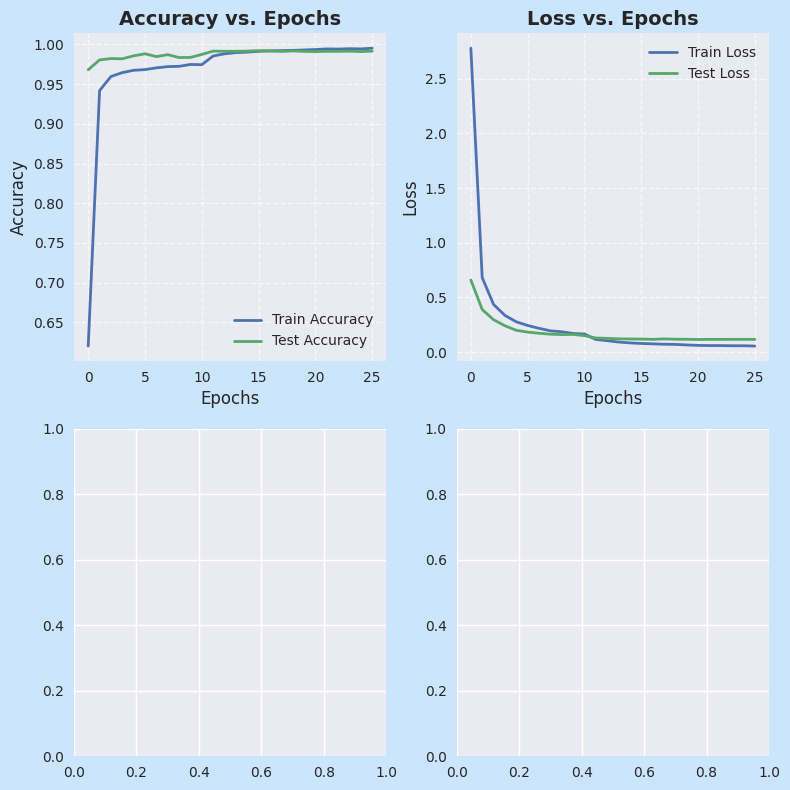

In [ ]:
import matplotlib.pyplot as plt

# Your data and plot commands...

plt.style.use('seaborn')  # Set a specific style, such as 'seaborn'

fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Create a 2x2 subplot grid

fig.patch.set_facecolor('#CCE5FF')  # Set light blue background color

# First subplot
axs[0, 0].set_title('Accuracy vs. Epochs', fontsize=14, fontweight='bold')
axs[0, 0].plot(train_accuracy, label='Train Accuracy', linewidth=2)
axs[0, 0].plot(val_accuracy, label='Test Accuracy', linewidth=2)
axs[0, 0].set_xlabel('Epochs', fontsize=12)
axs[0, 0].set_ylabel('Accuracy', fontsize=12)
axs[0, 0].legend(loc='best', fontsize=10)
axs[0, 0].tick_params(axis='both', which='major', labelsize=10)
axs[0, 0].grid(True, linestyle='--', alpha=0.7)

# Second subplot
axs[0, 1].set_title('Loss vs. Epochs', fontsize=14, fontweight='bold')
axs[0, 1].plot(train_loss, label='Train Loss', linewidth=2)
axs[0, 1].plot(val_loss, label='Test Loss', linewidth=2)
axs[0, 1].set_xlabel('Epochs', fontsize=12)
axs[0, 1].set_ylabel('Loss', fontsize=12)
axs[0, 1].legend(loc='best', fontsize=10)
axs[0, 1].tick_params(axis='both', which='major', labelsize=10)
axs[0, 1].grid(True, linestyle='--', alpha=0.7)

# Additional customization or more subplots can be added here...

plt.tight_layout()
plt.show()

In [ ]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

In [ ]:
# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

842/842 [==============================] - 120s 135ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#  the true labels and predicted labels for the validation dataset
y_true = test_generator.classes
y_pred = model1.predict(test_generator).argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

842/842 [==============================] - 113s 134ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have predicted probabilities and true labels for multi-class classification
true_labels = test_generator.classes
predictions = model1.predict(test_generator)

# Get the number of classes
num_classes = len(np.unique(true_labels))

# Initialize variables to store fpr and tpr for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    # Convert true labels to binary format (0 or 1) for the current class
    binary_true_labels = np.where(true_labels == i, 1, 0)

    # Compute ROC curve and ROC AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(binary_true_labels, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the class weights based on the number of true instances for each class
class_counts = np.bincount(true_labels)
class_weights = class_counts / float(len(true_labels))

# Calculate the weighted average ROC-AUC across classes
weighted_roc_auc = np.average(list(roc_auc.values()), weights=class_weights)

842/842 [==============================] - 112s 133ms/step


In [ ]:
print(f"Weighted Average ROC-AUC: {weighted_roc_auc:.4f}")

Weighted Average ROC-AUC: 0.9997


842/842 [==============================] - 114s 135ms/step


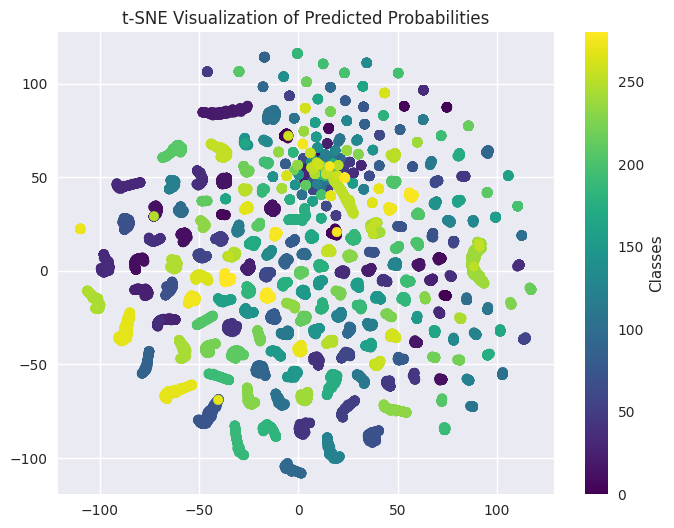

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have predicted probabilities and true labels for multi-class classification
true_labels = test_generator.classes
predictions = model1.predict(test_generator)

# Perform t-SNE dimensionality reduction on predicted probabilities
tsne = TSNE(n_components=2, random_state=42)
predicted_tsne = tsne.fit_transform(predictions)

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
plt.scatter(predicted_tsne[:, 0], predicted_tsne[:, 1], c=true_labels, cmap='viridis')
plt.colorbar(label='Classes')
plt.title('t-SNE Visualization of Predicted Probabilities')
plt.grid(True)
plt.show()


In [ ]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[33  0  0 ...  0  0  0]
 [ 0 47  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 62  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0 75]]


In [ ]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.96      0.98      0.97        48
           2       1.00      1.00      1.00        29
           3       0.98      1.00      0.99        58
           4       1.00      1.00      1.00        27
           5       1.00      0.95      0.98        42
           6       1.00      1.00      1.00        27
           7       0.95      1.00      0.97        38
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00        97
          10       1.00      0.94      0.97        83
          11       1.00      1.00      1.00        36
          12       0.99      1.00      0.99        74
          13       1.00      1.00      1.00        68
          14       0.97      1.00      0.99        68
          15       1.00      1.00      1.00        40
          16       0.92      1.00      0.96        36
    